In [1]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.ml.feature import RFormula
from pyspark.ml.classification import RandomForestClassifier as sparkRFClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier as sklearnRFClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import time
import os

### Initialize Spark Context and Session

In [2]:
sc = SparkContext()
spark = SparkSession(sc)

### Looking at the data

In [3]:
os.listdir('/home/jovyan/air_example')

['test.csv',
 'train-0.001m.csv',
 'train-0.01m.csv',
 'train-0.1m.csv',
 'train-1.0m.csv',
 'train-10.0m.csv',
 'valid.csv']

In [4]:
train_raw = spark.read.csv('/home/jovyan/air_example/train-0.001m.csv', header = True, inferSchema=True)
train_raw.show(10)

+-----+----------+---------+-------+-------------+------+----+--------+-----------------+
|Month|DayofMonth|DayOfWeek|DepTime|UniqueCarrier|Origin|Dest|Distance|dep_delayed_15min|
+-----+----------+---------+-------+-------------+------+----+--------+-----------------+
| c-10|      c-25|      c-3|    840|           B6|   IAD| BOS|     413|                N|
| c-12|      c-13|      c-3|    853|           UA|   LAX| KOA|    2504|                N|
|  c-9|       c-5|      c-2|   1541|           OH|   SAT| CVG|    1024|                N|
|  c-5|      c-12|      c-4|   1812|           F9|   DEN| LAX|     862|                Y|
|  c-5|      c-30|      c-2|   1028|           WN|   PIT| LAS|    1910|                N|
|  c-5|      c-31|      c-2|   2254|           OH|   CVG| DTW|     229|                N|
|  c-4|       c-8|      c-5|   1807|           XE|   IAD| EWR|     213|                Y|
|  c-1|      c-27|      c-5|   1608|           YV|   CLT| ROC|     573|                N|
|  c-6|   

In [5]:
train_raw.groupby('dep_delayed_15min').count().show()

+-----------------+-----+
|dep_delayed_15min|count|
+-----------------+-----+
|                Y|  219|
|                N|  781|
+-----------------+-----+



### Due to some Java/Python bug in this Docker container, for 100K+ datasets need to go through Pandas (#facepalm)

In [6]:
def get_data_spark_df(n=None):
    file_name = 'test' if n is None else 'train-' + str(n/1e6) + 'm'
    pd_df = pd.read_csv('/home/jovyan/air_example/' + file_name + '.csv', header = 0)
    spark_df = spark.createDataFrame(pd_df)
    return spark_df

In [7]:
train_raw = get_data_spark_df(1000)
train_raw.count()

1000

In [8]:
test_raw = get_data_spark_df()
test_raw.count()

100000

### Getting data ready for Random Forest

In [9]:
formula = RFormula(formula='dep_delayed_15min ~ .', featuresCol='features', labelCol='label')

In [10]:
def process_df_for_spark_rf(train, test):
    train_test = train.union(test)
    formula_fit = formula.fit(train_test)
    train_df = formula_fit.transform(train)
    test_df = formula_fit.transform(test)
    return train_df, test_df

In [11]:
train_df, test_df = process_df_for_spark_rf(train_raw, test_raw)

### Training Random Forest

In [12]:
def fit_spark_rf(train_df, test_df, n_trees=100):
    rf = sparkRFClassifier(numTrees=n_trees)
    rfModel = rf.fit(train_df)
    pred_df = rfModel.transform(test_df)    
    evaluator = BinaryClassificationEvaluator(rawPredictionCol='rawPrediction')
    auc = evaluator.evaluate(pred_df)
    return auc

In [13]:
auc = fit_spark_rf(train_df, test_df)
print('Test AUC for n = 1000: %.2f' % auc)

Test AUC for n = 1000: 0.62


### all together now, recording time

In [14]:
def sparkRF(n):
    train_raw = get_data_spark_df(n=n)
    train_df, test_df = process_df_for_spark_rf(train_raw, test_raw)
    start = time.time()
    auc = fit_spark_rf(train_df, test_df)
    end = time.time()
    return auc, end - start

In [15]:
sp_aucs = []
sp_times = []
ns =  [1e3, 1e4, 1e5, 1e6]
for n in ns:
    auc, t = sparkRF(n = n)
    sp_aucs.append(auc)
    sp_times.append(t)
    print('Finished with n %d' % n)

print(sp_aucs)
print(sp_times)

Finished with n 1000
Finished with n 10000
Finished with n 100000
Finished with n 1000000
[0.6234234392694245, 0.6546855656662904, 0.6903747146009722, 0.6851279032611572]
[3.687950372695923, 4.2442052364349365, 12.320148468017578, 100.52383041381836]


### Now Sklearn

In [16]:
def get_data_sklearn_df(n=None):
    file_name = 'test' if n is None else 'train-' + str(n/1e6) + 'm'
    pd_df = pd.read_csv('/home/jovyan/air_example/' + file_name + '.csv', header = 0)
    return pd_df

In [17]:
test_raw = get_data_sklearn_df()

In [18]:
def process_df_for_sklearn_rf(train, test):
    train_test = pd.concat([train, test])
    encoder = OneHotEncoder(handle_unknown='ignore')
    encoder.fit(train_test.iloc[:, :8])
    X_train = encoder.transform(train.iloc[:, :8])
    X_test = encoder.transform(test.iloc[:, :8])
    y_train = train.iloc[:, 8]
    y_test = test.iloc[:, 8]
    return (X_train, y_train), (X_test, y_test)

In [19]:
def fit_sklearn_rf(X_train, y_train, X_test, y_test, n_trees=100):
    rf = sklearnRFClassifier(n_estimators=n_trees)
    rfModel = rf.fit(X_train, y_train)
    y_pred = rfModel.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_pred)
    return auc

In [20]:
def sklearnRF(n):
    train_raw = get_data_sklearn_df(n=n)
    (X_train, y_train), (X_test, y_test) = process_df_for_sklearn_rf(train_raw, test_raw)
    start = time.time()
    auc = fit_sklearn_rf(X_train, y_train, X_test, y_test)
    end = time.time()
    return auc, end - start

In [21]:
sk_aucs = []
sk_times = []
ns =  [1e3, 1e4, 1e5, 1e6]
for n in ns:
    auc, t = sklearnRF(n = n)
    sk_aucs.append(auc)
    sk_times.append(t)
    print('Finished with n %d' % n)

print(sk_aucs)
print(sk_times)

Finished with n 1000
Finished with n 10000
Finished with n 100000
Finished with n 1000000
[0.5325995705640231, 0.5805406366552638, 0.6212220689858309, 0.6545115323354885]
[2.8794918060302734, 14.525564908981323, 184.4529995918274, 21334.869365930557]


### Let us compare

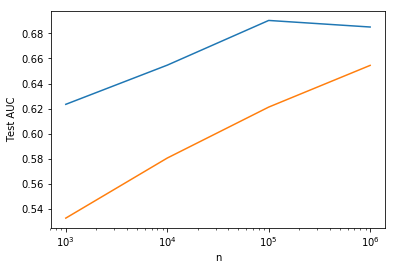

In [22]:
plt.plot(ns, sp_aucs, ns, sk_aucs)
plt.xlabel('n')
plt.ylabel('Test AUC')
plt.xscale('log')
plt.show()

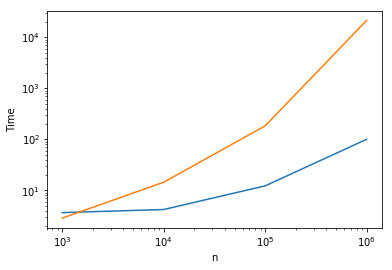

In [23]:
plt.plot(ns, sp_times, ns, sk_times)
plt.xlabel('n')
plt.ylabel('Time')
plt.xscale('log')
plt.yscale('log')
plt.show()